# Content

In this notebook, we will train a Character level RNN.

Character level means that instead of generating complete WORDS(or a complete word at a time) like in a word level RNN, our model will learn to generate individual characters(one single character at a time).

This approach have a few benefits over word level RNN, like:

1. Smaller vocabulary size: Instead of our vocabulary size consisting of all unique word of the corpus, it simply consists of unique characters
2. Easier tokenization: The tokenization simply consists of breaking down the text into characters

For our model, we will use the Tiny Shakespeare dataset. It consists of a single text file containing a selection of works by William Shakespeare, specifically his plays.


In [1]:
from IPython.display import clear_output

In [2]:
# %pip install numpy matplotlib torch tqdm requests

clear_output()

In [3]:
import random
import requests

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

## Loading the data

In [4]:
# Load the dataset
dataset_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
shakespeare_text = requests.get(dataset_url).text

In [5]:
# Create a mapping from character to index and vice versa

unique_chars = sorted(list(set(shakespeare_text)))
vocab_size = len(unique_chars)
char_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
idx_to_char = {idx: char for idx, char in enumerate(unique_chars)}

In [6]:
# Encode the dataset into integer indices

encoded_sp_text = torch.Tensor([char_to_idx[char] for char in tqdm(shakespeare_text)]).type(torch.long)

100%|██████████| 1115394/1115394 [00:00<00:00, 6535894.13it/s]


In [7]:
encoded_sp_text.shape

torch.Size([1115394])

## Defining the dataset class

In [8]:
class ShakeSpeareCharactersDataset(Dataset):

    def __init__(self, encoded_sp_text, seq_len=100):

        self.encoded_sp_text = encoded_sp_text
        self.seq_len = seq_len

    def __len__(self):
        # We will randomly sample parts of text in this dataset and return them so we don't have a specific length, so we can define it anything.
        # Note that this length will be used as number of samples per epoch. Increasing this will increase the number of samples processed per epoch.
        return 5000

    def __getitem__(self, idx):

        start_idx = random.randint(0, len(self.encoded_sp_text) - self.seq_len)
        end_idx = start_idx + self.seq_len

        # calling torch.Tensor on a value that's already possibly tensor because:
        # 1. If it's not a tensor, it'll be converted to one
        # 2. If it's already a tensor, It's safer to make a copy of it and this will do just that.
        text = torch.Tensor(self.encoded_sp_text[start_idx:end_idx])
        return text


In [109]:
train_dataset = ShakeSpeareCharactersDataset(encoded_sp_text, seq_len=200)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Defining the model

In [110]:
class CharRNN(nn.Module):

    def __init__(self, vocab_size, hidden_size, num_layers):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embed(x)
        out, hidden = self.rnn(x, hidden)
        out = out.reshape(out.size(0) * out.size(1), self.hidden_size)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

## Training the model

In [115]:
# Hyperparameters
hidden_size = 256
num_layers = 3
num_epochs = 200
learning_rate = 5e-4

In [116]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [117]:
# Model, Loss, Optimizer
model = CharRNN(vocab_size, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [118]:
train_losses = []

In [119]:
model.train()
model.to(device)

CharRNN(
  (embed): Embedding(65, 256)
  (rnn): RNN(256, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=65, bias=True)
)

In [120]:
# Training loop
for epoch in range(num_epochs):

    for encoded_text_batch in tqdm(train_loader):

        # .shape[0] for batch size. cannot use batch_size variable because actual batch can be smaller(when not enough elements left to make full batch)
        hidden = model.init_hidden(encoded_text_batch.shape[0]).to(device)

        inputs, targets = encoded_text_batch[..., :-1], encoded_text_batch[..., 1:]
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs, hidden = model(inputs, hidden)
        loss = criterion(outputs, targets.reshape(-1))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        train_losses.append(loss.item())

100%|██████████| 79/79 [00:01<00:00, 77.72it/s]


Epoch [1/200], Loss: 2.2375


100%|██████████| 79/79 [00:00<00:00, 96.33it/s]


Epoch [2/200], Loss: 1.9837


100%|██████████| 79/79 [00:00<00:00, 97.89it/s] 


Epoch [3/200], Loss: 1.8427


100%|██████████| 79/79 [00:00<00:00, 97.28it/s] 


Epoch [4/200], Loss: 1.6983


100%|██████████| 79/79 [00:00<00:00, 97.52it/s] 


Epoch [5/200], Loss: 1.6950


100%|██████████| 79/79 [00:00<00:00, 97.88it/s] 


Epoch [6/200], Loss: 1.6285


100%|██████████| 79/79 [00:00<00:00, 97.78it/s] 


Epoch [7/200], Loss: 1.5862


100%|██████████| 79/79 [00:00<00:00, 97.05it/s] 


Epoch [8/200], Loss: 1.4955


100%|██████████| 79/79 [00:00<00:00, 97.75it/s]


Epoch [9/200], Loss: 1.4793


100%|██████████| 79/79 [00:00<00:00, 97.40it/s]


Epoch [10/200], Loss: 1.5257


100%|██████████| 79/79 [00:00<00:00, 96.75it/s]


Epoch [11/200], Loss: 1.5220


100%|██████████| 79/79 [00:00<00:00, 97.13it/s]


Epoch [12/200], Loss: 1.5468


100%|██████████| 79/79 [00:00<00:00, 96.21it/s]


Epoch [13/200], Loss: 1.4444


100%|██████████| 79/79 [00:00<00:00, 96.69it/s]


Epoch [14/200], Loss: 1.4537


100%|██████████| 79/79 [00:00<00:00, 95.50it/s] 


Epoch [15/200], Loss: 1.3676


100%|██████████| 79/79 [00:00<00:00, 95.15it/s]


Epoch [16/200], Loss: 1.3790


100%|██████████| 79/79 [00:00<00:00, 95.73it/s]


Epoch [17/200], Loss: 1.4242


100%|██████████| 79/79 [00:00<00:00, 95.61it/s]


Epoch [18/200], Loss: 1.4129


100%|██████████| 79/79 [00:00<00:00, 95.81it/s]


Epoch [19/200], Loss: 1.2923


100%|██████████| 79/79 [00:00<00:00, 95.57it/s]


Epoch [20/200], Loss: 1.3460


100%|██████████| 79/79 [00:00<00:00, 95.77it/s]


Epoch [21/200], Loss: 1.2769


100%|██████████| 79/79 [00:00<00:00, 95.97it/s]


Epoch [22/200], Loss: 1.4194


100%|██████████| 79/79 [00:00<00:00, 95.03it/s]


Epoch [23/200], Loss: 1.3156


100%|██████████| 79/79 [00:00<00:00, 95.85it/s]


Epoch [24/200], Loss: 1.4185


100%|██████████| 79/79 [00:00<00:00, 95.38it/s] 


Epoch [25/200], Loss: 1.4361


100%|██████████| 79/79 [00:00<00:00, 95.49it/s]


Epoch [26/200], Loss: 1.3515


100%|██████████| 79/79 [00:00<00:00, 95.42it/s]


Epoch [27/200], Loss: 1.3246


100%|██████████| 79/79 [00:00<00:00, 94.92it/s]


Epoch [28/200], Loss: 1.3122


100%|██████████| 79/79 [00:00<00:00, 95.15it/s]


Epoch [29/200], Loss: 1.3099


100%|██████████| 79/79 [00:00<00:00, 94.81it/s]


Epoch [30/200], Loss: 1.2549


100%|██████████| 79/79 [00:00<00:00, 94.81it/s]


Epoch [31/200], Loss: 1.3712


100%|██████████| 79/79 [00:00<00:00, 94.57it/s]


Epoch [32/200], Loss: 1.3047


100%|██████████| 79/79 [00:00<00:00, 94.95it/s]


Epoch [33/200], Loss: 1.3043


100%|██████████| 79/79 [00:00<00:00, 94.46it/s]


Epoch [34/200], Loss: 1.2687


100%|██████████| 79/79 [00:00<00:00, 94.01it/s]


Epoch [35/200], Loss: 1.2872


100%|██████████| 79/79 [00:00<00:00, 94.00it/s]


Epoch [36/200], Loss: 1.3144


100%|██████████| 79/79 [00:00<00:00, 93.45it/s]


Epoch [37/200], Loss: 1.2655


100%|██████████| 79/79 [00:01<00:00, 40.07it/s]


Epoch [38/200], Loss: 1.1956


100%|██████████| 79/79 [00:00<00:00, 91.26it/s]


Epoch [39/200], Loss: 1.1005


100%|██████████| 79/79 [00:00<00:00, 90.84it/s]


Epoch [40/200], Loss: 1.3663


100%|██████████| 79/79 [00:00<00:00, 88.99it/s]


Epoch [41/200], Loss: 1.3771


100%|██████████| 79/79 [00:00<00:00, 86.21it/s]


Epoch [42/200], Loss: 1.2565


100%|██████████| 79/79 [00:00<00:00, 87.80it/s]


Epoch [43/200], Loss: 1.3415


100%|██████████| 79/79 [00:00<00:00, 90.54it/s]


Epoch [44/200], Loss: 1.3513


100%|██████████| 79/79 [00:00<00:00, 91.49it/s]


Epoch [45/200], Loss: 1.2736


100%|██████████| 79/79 [00:00<00:00, 91.05it/s]


Epoch [46/200], Loss: 1.2112


100%|██████████| 79/79 [00:00<00:00, 92.24it/s]


Epoch [47/200], Loss: 1.2952


100%|██████████| 79/79 [00:00<00:00, 91.79it/s]


Epoch [48/200], Loss: 1.2539


100%|██████████| 79/79 [00:00<00:00, 92.55it/s]


Epoch [49/200], Loss: 1.2579


100%|██████████| 79/79 [00:00<00:00, 91.01it/s]


Epoch [50/200], Loss: 1.2250


100%|██████████| 79/79 [00:00<00:00, 90.97it/s]


Epoch [51/200], Loss: 1.2670


100%|██████████| 79/79 [00:00<00:00, 90.99it/s]


Epoch [52/200], Loss: 1.2417


100%|██████████| 79/79 [00:00<00:00, 91.10it/s]


Epoch [53/200], Loss: 1.2019


100%|██████████| 79/79 [00:00<00:00, 91.15it/s]


Epoch [54/200], Loss: 1.2498


100%|██████████| 79/79 [00:00<00:00, 90.84it/s]


Epoch [55/200], Loss: 1.1459


100%|██████████| 79/79 [00:00<00:00, 89.75it/s]


Epoch [56/200], Loss: 1.2425


100%|██████████| 79/79 [00:00<00:00, 87.64it/s]


Epoch [57/200], Loss: 1.1639


100%|██████████| 79/79 [00:00<00:00, 90.45it/s]


Epoch [58/200], Loss: 1.1572


100%|██████████| 79/79 [00:00<00:00, 89.77it/s]


Epoch [59/200], Loss: 1.1946


100%|██████████| 79/79 [00:00<00:00, 85.34it/s]


Epoch [60/200], Loss: 1.1241


100%|██████████| 79/79 [00:00<00:00, 87.13it/s]


Epoch [61/200], Loss: 1.2177


100%|██████████| 79/79 [00:00<00:00, 88.66it/s]


Epoch [62/200], Loss: 1.2801


100%|██████████| 79/79 [00:00<00:00, 89.23it/s]


Epoch [63/200], Loss: 1.2707


100%|██████████| 79/79 [00:00<00:00, 89.52it/s]


Epoch [64/200], Loss: 1.2585


100%|██████████| 79/79 [00:00<00:00, 89.73it/s]


Epoch [65/200], Loss: 1.1800


100%|██████████| 79/79 [00:00<00:00, 88.18it/s]


Epoch [66/200], Loss: 1.1998


100%|██████████| 79/79 [00:00<00:00, 88.67it/s]


Epoch [67/200], Loss: 1.1905


100%|██████████| 79/79 [00:00<00:00, 89.16it/s]


Epoch [68/200], Loss: 1.2916


100%|██████████| 79/79 [00:00<00:00, 86.81it/s]


Epoch [69/200], Loss: 1.1441


100%|██████████| 79/79 [00:00<00:00, 82.71it/s]


Epoch [70/200], Loss: 1.1377


100%|██████████| 79/79 [00:00<00:00, 86.67it/s]


Epoch [71/200], Loss: 1.1729


100%|██████████| 79/79 [00:00<00:00, 84.25it/s]


Epoch [72/200], Loss: 1.2161


100%|██████████| 79/79 [00:00<00:00, 87.33it/s]


Epoch [73/200], Loss: 1.2504


100%|██████████| 79/79 [00:00<00:00, 85.85it/s]


Epoch [74/200], Loss: 1.1428


100%|██████████| 79/79 [00:00<00:00, 87.10it/s]


Epoch [75/200], Loss: 1.1246


100%|██████████| 79/79 [00:00<00:00, 82.59it/s]


Epoch [76/200], Loss: 1.2412


100%|██████████| 79/79 [00:00<00:00, 83.21it/s]


Epoch [77/200], Loss: 1.1516


100%|██████████| 79/79 [00:00<00:00, 82.84it/s]


Epoch [78/200], Loss: 1.1440


100%|██████████| 79/79 [00:00<00:00, 84.39it/s]


Epoch [79/200], Loss: 1.1832


100%|██████████| 79/79 [00:00<00:00, 81.72it/s]


Epoch [80/200], Loss: 1.2276


100%|██████████| 79/79 [00:00<00:00, 83.56it/s]


Epoch [81/200], Loss: 1.2065


100%|██████████| 79/79 [00:00<00:00, 80.45it/s]


Epoch [82/200], Loss: 1.1109


100%|██████████| 79/79 [00:01<00:00, 77.37it/s]


Epoch [83/200], Loss: 1.1050


100%|██████████| 79/79 [00:01<00:00, 78.26it/s]


Epoch [84/200], Loss: 1.2480


100%|██████████| 79/79 [00:00<00:00, 79.42it/s]


Epoch [85/200], Loss: 1.1067


100%|██████████| 79/79 [00:01<00:00, 75.06it/s]


Epoch [86/200], Loss: 1.1936


100%|██████████| 79/79 [00:00<00:00, 79.34it/s]


Epoch [87/200], Loss: 1.1521


100%|██████████| 79/79 [00:01<00:00, 78.43it/s]


Epoch [88/200], Loss: 1.1751


100%|██████████| 79/79 [00:00<00:00, 79.80it/s]


Epoch [89/200], Loss: 1.1800


100%|██████████| 79/79 [00:00<00:00, 80.13it/s]


Epoch [90/200], Loss: 1.1510


100%|██████████| 79/79 [00:01<00:00, 75.62it/s]


Epoch [91/200], Loss: 1.2118


100%|██████████| 79/79 [00:01<00:00, 76.22it/s]


Epoch [92/200], Loss: 1.2691


100%|██████████| 79/79 [00:01<00:00, 77.98it/s]


Epoch [93/200], Loss: 1.2051


100%|██████████| 79/79 [00:01<00:00, 77.23it/s]


Epoch [94/200], Loss: 1.1079


100%|██████████| 79/79 [00:01<00:00, 74.93it/s]


Epoch [95/200], Loss: 1.1515


100%|██████████| 79/79 [00:01<00:00, 70.79it/s]


Epoch [96/200], Loss: 1.0966


100%|██████████| 79/79 [00:01<00:00, 76.01it/s]


Epoch [97/200], Loss: 1.1111


100%|██████████| 79/79 [00:01<00:00, 74.62it/s]


Epoch [98/200], Loss: 1.1367


100%|██████████| 79/79 [00:01<00:00, 72.75it/s]


Epoch [99/200], Loss: 1.1757


100%|██████████| 79/79 [00:01<00:00, 68.31it/s]


Epoch [100/200], Loss: 1.1484


100%|██████████| 79/79 [00:01<00:00, 71.16it/s]


Epoch [101/200], Loss: 1.1977


100%|██████████| 79/79 [00:01<00:00, 68.21it/s]


Epoch [102/200], Loss: 1.0942


100%|██████████| 79/79 [00:01<00:00, 64.70it/s]


Epoch [103/200], Loss: 1.1954


100%|██████████| 79/79 [00:01<00:00, 72.15it/s]


Epoch [104/200], Loss: 1.0532


100%|██████████| 79/79 [00:01<00:00, 67.52it/s]


Epoch [105/200], Loss: 1.0806


100%|██████████| 79/79 [00:01<00:00, 58.39it/s]


Epoch [106/200], Loss: 1.1389


100%|██████████| 79/79 [00:01<00:00, 69.05it/s]


Epoch [107/200], Loss: 1.1327


100%|██████████| 79/79 [00:01<00:00, 65.22it/s]


Epoch [108/200], Loss: 1.0507


100%|██████████| 79/79 [00:01<00:00, 63.79it/s]


Epoch [109/200], Loss: 1.1117


100%|██████████| 79/79 [00:01<00:00, 73.53it/s]


Epoch [110/200], Loss: 1.1817


100%|██████████| 79/79 [00:01<00:00, 68.97it/s]


Epoch [111/200], Loss: 1.1223


100%|██████████| 79/79 [00:01<00:00, 71.66it/s]


Epoch [112/200], Loss: 1.0829


100%|██████████| 79/79 [00:01<00:00, 67.02it/s]


Epoch [113/200], Loss: 1.1135


100%|██████████| 79/79 [00:01<00:00, 64.12it/s]


Epoch [114/200], Loss: 1.1347


100%|██████████| 79/79 [00:01<00:00, 66.58it/s]


Epoch [115/200], Loss: 1.0356


100%|██████████| 79/79 [00:01<00:00, 62.07it/s]


Epoch [116/200], Loss: 1.1205


100%|██████████| 79/79 [00:01<00:00, 65.47it/s]


Epoch [117/200], Loss: 1.1644


100%|██████████| 79/79 [00:01<00:00, 66.87it/s]


Epoch [118/200], Loss: 1.1345


100%|██████████| 79/79 [00:01<00:00, 73.15it/s]


Epoch [119/200], Loss: 1.0617


100%|██████████| 79/79 [00:01<00:00, 70.93it/s]


Epoch [120/200], Loss: 1.1049


100%|██████████| 79/79 [00:01<00:00, 51.17it/s]


Epoch [121/200], Loss: 1.1400


100%|██████████| 79/79 [00:01<00:00, 65.21it/s]


Epoch [122/200], Loss: 1.0703


100%|██████████| 79/79 [00:01<00:00, 64.14it/s]


Epoch [123/200], Loss: 1.1776


100%|██████████| 79/79 [00:01<00:00, 75.93it/s]


Epoch [124/200], Loss: 1.1056


100%|██████████| 79/79 [00:01<00:00, 72.11it/s]


Epoch [125/200], Loss: 1.0601


100%|██████████| 79/79 [00:01<00:00, 75.16it/s]


Epoch [126/200], Loss: 1.1048


100%|██████████| 79/79 [00:01<00:00, 75.76it/s]


Epoch [127/200], Loss: 1.1303


100%|██████████| 79/79 [00:01<00:00, 69.89it/s]


Epoch [128/200], Loss: 1.0741


100%|██████████| 79/79 [00:01<00:00, 72.23it/s]


Epoch [129/200], Loss: 1.0426


100%|██████████| 79/79 [00:01<00:00, 76.31it/s]


Epoch [130/200], Loss: 1.1283


100%|██████████| 79/79 [00:01<00:00, 65.99it/s]


Epoch [131/200], Loss: 1.1164


100%|██████████| 79/79 [00:01<00:00, 59.79it/s]


Epoch [132/200], Loss: 1.0819


100%|██████████| 79/79 [00:01<00:00, 71.85it/s]


Epoch [133/200], Loss: 1.0550


100%|██████████| 79/79 [00:01<00:00, 74.98it/s]


Epoch [134/200], Loss: 1.0976


100%|██████████| 79/79 [00:01<00:00, 72.49it/s]


Epoch [135/200], Loss: 1.2128


100%|██████████| 79/79 [00:01<00:00, 67.99it/s]


Epoch [136/200], Loss: 1.1240


100%|██████████| 79/79 [00:01<00:00, 62.93it/s]


Epoch [137/200], Loss: 1.0899


100%|██████████| 79/79 [00:01<00:00, 70.28it/s]


Epoch [138/200], Loss: 1.0434


100%|██████████| 79/79 [00:01<00:00, 71.79it/s]


Epoch [139/200], Loss: 1.0747


100%|██████████| 79/79 [00:01<00:00, 69.34it/s]


Epoch [140/200], Loss: 1.1251


100%|██████████| 79/79 [00:01<00:00, 72.15it/s]


Epoch [141/200], Loss: 1.0362


100%|██████████| 79/79 [00:01<00:00, 71.01it/s]


Epoch [142/200], Loss: 1.0749


100%|██████████| 79/79 [00:01<00:00, 72.51it/s]


Epoch [143/200], Loss: 1.0466


100%|██████████| 79/79 [00:01<00:00, 68.05it/s]


Epoch [144/200], Loss: 1.0914


100%|██████████| 79/79 [00:01<00:00, 74.36it/s]


Epoch [145/200], Loss: 1.0675


100%|██████████| 79/79 [00:01<00:00, 73.92it/s]


Epoch [146/200], Loss: 1.0533


100%|██████████| 79/79 [00:01<00:00, 70.26it/s]


Epoch [147/200], Loss: 1.0765


100%|██████████| 79/79 [00:01<00:00, 71.66it/s]


Epoch [148/200], Loss: 1.1152


100%|██████████| 79/79 [00:01<00:00, 71.62it/s]


Epoch [149/200], Loss: 1.1216


100%|██████████| 79/79 [00:01<00:00, 71.34it/s]


Epoch [150/200], Loss: 1.0681


100%|██████████| 79/79 [00:01<00:00, 70.59it/s]


Epoch [151/200], Loss: 1.0475


100%|██████████| 79/79 [00:01<00:00, 75.73it/s]


Epoch [152/200], Loss: 1.0042


100%|██████████| 79/79 [00:01<00:00, 62.87it/s]


Epoch [153/200], Loss: 1.0068


100%|██████████| 79/79 [00:01<00:00, 54.96it/s]


Epoch [154/200], Loss: 1.0619


100%|██████████| 79/79 [00:01<00:00, 70.81it/s]


Epoch [155/200], Loss: 0.9973


100%|██████████| 79/79 [00:01<00:00, 73.21it/s]


Epoch [156/200], Loss: 1.1051


100%|██████████| 79/79 [00:01<00:00, 62.07it/s]


Epoch [157/200], Loss: 1.0769


100%|██████████| 79/79 [00:01<00:00, 74.11it/s]


Epoch [158/200], Loss: 1.0485


100%|██████████| 79/79 [00:01<00:00, 71.51it/s]


Epoch [159/200], Loss: 1.0476


100%|██████████| 79/79 [00:01<00:00, 75.22it/s]


Epoch [160/200], Loss: 1.0437


100%|██████████| 79/79 [00:01<00:00, 74.34it/s]


Epoch [161/200], Loss: 1.0354


100%|██████████| 79/79 [00:01<00:00, 73.64it/s]


Epoch [162/200], Loss: 1.0429


100%|██████████| 79/79 [00:01<00:00, 69.59it/s]


Epoch [163/200], Loss: 0.9815


100%|██████████| 79/79 [00:01<00:00, 73.48it/s]


Epoch [164/200], Loss: 1.0551


100%|██████████| 79/79 [00:01<00:00, 65.22it/s]


Epoch [165/200], Loss: 1.1087


100%|██████████| 79/79 [00:01<00:00, 77.69it/s]


Epoch [166/200], Loss: 1.0051


100%|██████████| 79/79 [00:01<00:00, 69.62it/s]


Epoch [167/200], Loss: 1.0538


100%|██████████| 79/79 [00:01<00:00, 75.93it/s]


Epoch [168/200], Loss: 1.0555


100%|██████████| 79/79 [00:01<00:00, 75.70it/s]


Epoch [169/200], Loss: 1.0242


100%|██████████| 79/79 [00:01<00:00, 72.98it/s]


Epoch [170/200], Loss: 1.0830


100%|██████████| 79/79 [00:01<00:00, 71.45it/s]


Epoch [171/200], Loss: 1.1395


100%|██████████| 79/79 [00:01<00:00, 71.74it/s]


Epoch [172/200], Loss: 1.0488


100%|██████████| 79/79 [00:01<00:00, 71.23it/s]


Epoch [173/200], Loss: 1.0691


100%|██████████| 79/79 [00:01<00:00, 72.56it/s]


Epoch [174/200], Loss: 1.0698


100%|██████████| 79/79 [00:01<00:00, 73.60it/s]


Epoch [175/200], Loss: 1.0120


100%|██████████| 79/79 [00:01<00:00, 76.98it/s]


Epoch [176/200], Loss: 1.0656


100%|██████████| 79/79 [00:01<00:00, 70.44it/s]


Epoch [177/200], Loss: 1.0227


100%|██████████| 79/79 [00:01<00:00, 63.48it/s]


Epoch [178/200], Loss: 0.9291


100%|██████████| 79/79 [00:01<00:00, 73.79it/s]


Epoch [179/200], Loss: 1.0447


100%|██████████| 79/79 [00:01<00:00, 75.00it/s]


Epoch [180/200], Loss: 1.0994


100%|██████████| 79/79 [00:01<00:00, 72.92it/s]


Epoch [181/200], Loss: 1.0433


100%|██████████| 79/79 [00:01<00:00, 75.80it/s]


Epoch [182/200], Loss: 1.0107


100%|██████████| 79/79 [00:01<00:00, 76.51it/s]


Epoch [183/200], Loss: 1.1028


100%|██████████| 79/79 [00:01<00:00, 71.91it/s]


Epoch [184/200], Loss: 1.0366


100%|██████████| 79/79 [00:01<00:00, 74.97it/s]


Epoch [185/200], Loss: 1.0038


100%|██████████| 79/79 [00:01<00:00, 74.55it/s]


Epoch [186/200], Loss: 1.0428


100%|██████████| 79/79 [00:01<00:00, 62.35it/s]


Epoch [187/200], Loss: 0.9774


100%|██████████| 79/79 [00:01<00:00, 64.61it/s]


Epoch [188/200], Loss: 1.1168


100%|██████████| 79/79 [00:01<00:00, 74.91it/s]


Epoch [189/200], Loss: 1.0153


100%|██████████| 79/79 [00:01<00:00, 60.90it/s]


Epoch [190/200], Loss: 0.9784


100%|██████████| 79/79 [00:01<00:00, 60.78it/s]


Epoch [191/200], Loss: 1.0344


100%|██████████| 79/79 [00:01<00:00, 48.98it/s]


Epoch [192/200], Loss: 1.0054


100%|██████████| 79/79 [00:01<00:00, 59.86it/s]


Epoch [193/200], Loss: 1.0517


100%|██████████| 79/79 [00:00<00:00, 80.96it/s]


Epoch [194/200], Loss: 1.0300


100%|██████████| 79/79 [00:01<00:00, 61.90it/s]


Epoch [195/200], Loss: 0.9851


100%|██████████| 79/79 [00:01<00:00, 63.33it/s]


Epoch [196/200], Loss: 0.9826


100%|██████████| 79/79 [00:01<00:00, 71.58it/s]


Epoch [197/200], Loss: 0.9861


100%|██████████| 79/79 [00:01<00:00, 75.62it/s]


Epoch [198/200], Loss: 1.0037


100%|██████████| 79/79 [00:01<00:00, 66.03it/s]


Epoch [199/200], Loss: 1.0031


100%|██████████| 79/79 [00:01<00:00, 75.58it/s]

Epoch [200/200], Loss: 0.9530


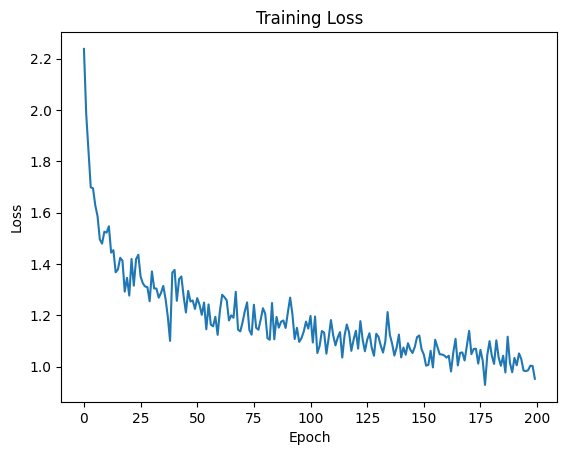

In [121]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [122]:
model.cpu()

CharRNN(
  (embed): Embedding(65, 256)
  (rnn): RNN(256, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=65, bias=True)
)

## Testing the model

In [123]:
def generate_text(model, start_str, length):
    model.eval()
    hidden = model.init_hidden(1)
    input = torch.tensor([[char_to_idx[char] for char in start_str]], dtype=torch.long)

    with torch.no_grad():

        generated_str = start_str
        for _ in range(length):
            output, hidden = model(input, hidden)
            char_idx = torch.argmax(output[-1]).item()
            char = idx_to_char[char_idx]
            generated_str += char
            input = torch.tensor([[char_idx]], dtype=torch.long)

    return generated_str

In [125]:
# Example generation
start_str = "Is th"
generated_text = generate_text(model, start_str, 300)
print(generated_text)

Is this the present action
Of whom he is a paradise, and the deed.

LADY ANNE:
Why, then I saw her maid, with the sea, may be thought on seess,
Were the devil that the deep as she hath made a charm
To be a shame to the warlike storm,
Hath not a short and folded mine arm,
To find the sun that I should hav


In [128]:
# Example generation
start_str = "Charm"
generated_text = generate_text(model, start_str, 300)
print(generated_text)

Charm your hands with the death.

KING RICHARD III:
Ay, what a shame of heaven so long
Is all the morning comes to see your lordship.

LUCENTIO:
I am the common people with a man
As thou art death hath set the prince than they are worth
Of the deep as long against
The common people with a man that I may 
